Total embedded bits: 131072
MSE: 0.24994277954101562
PSNR: 54.15239765691634 dB
-----------------------EXTRACTION--------------------------------

Extraction successful! The secret data matches.


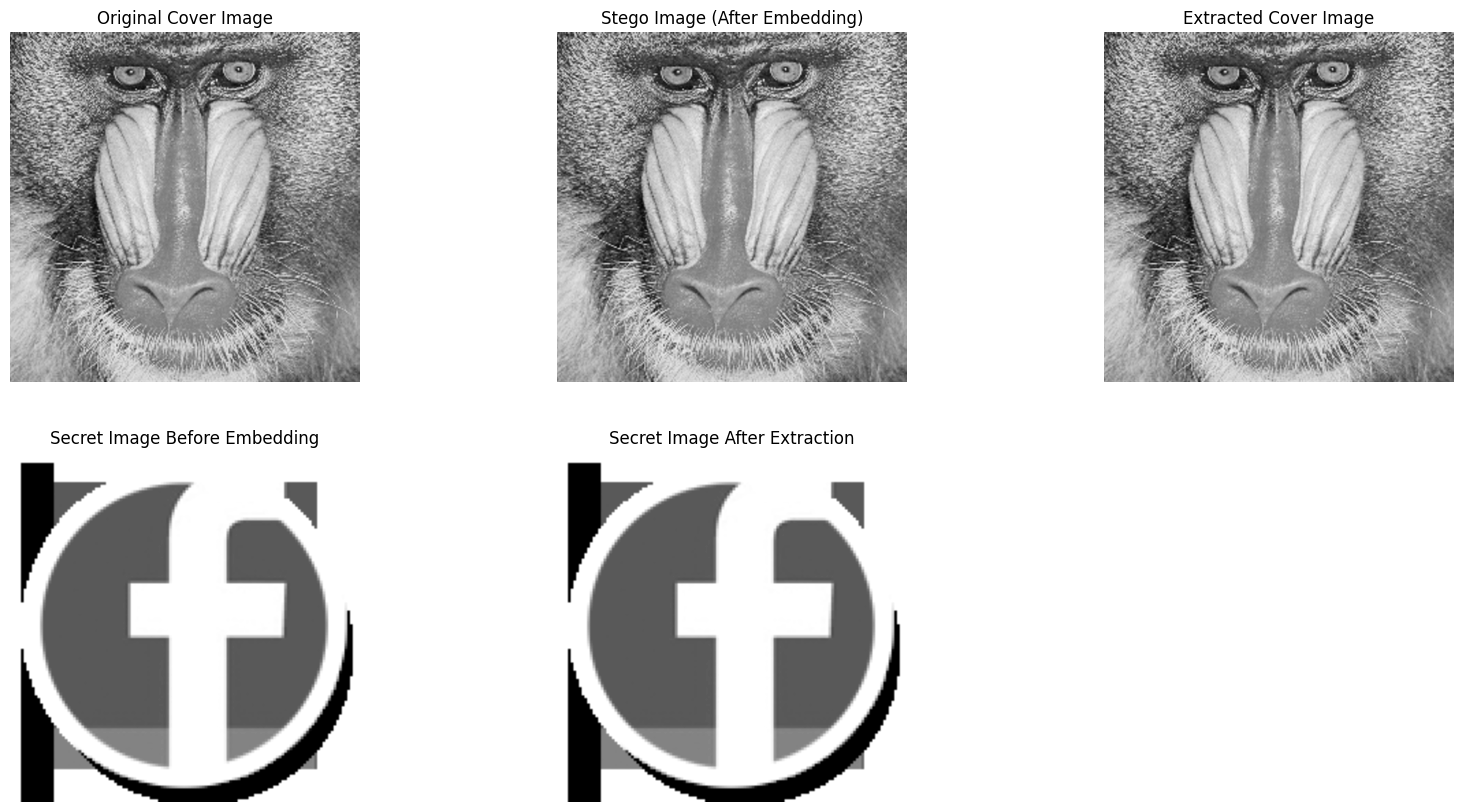

True

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import log10, sqrt

# Function to convert the secret image pixels into a binary bit stream
def image_to_binary_bit_stream(secret_image):
    # Flatten the image and convert each pixel to its 8-bit binary representation
    flattened_pixels = secret_image.flatten()
    bit_stream = ''.join([format(pixel, '08b') for pixel in flattened_pixels])
    bit_stream_arr = np.array([int(bit) for bit in bit_stream])
    return bit_stream_arr

# Function to convert the extracted bit stream back into a 128x128 image
def binary_bit_stream_to_image(extracted_bits, image_shape=(128, 128)):
    # Group every 8 bits into a byte and convert it back to a pixel value (0-255)
    pixel_values = [int(''.join(map(str, extracted_bits[i:i+8])), 2) for i in range(0, len(extracted_bits), 8)]
    return np.array(pixel_values).reshape(image_shape)

def embed(cover_image, secret, B=4):
    H, W = cover_image.shape
    num_blocks_H = H // B
    num_blocks_W = W // B
    stego_image = cover_image.copy()
    idx = 0  # To track the secret bits

    for i in range(num_blocks_H):
        for j in range(num_blocks_W):
            block = cover_image[i * B:(i + 1) * B, j * B:(j + 1) * B].flatten()

            for k in range(len(block)):
                if idx < len(secret):
                    # Modify the LSB of each pixel in the block to embed a secret bit
                    block[k] = (block[k] & ~1) | secret[idx]
                    idx += 1

            # Reshape block back and insert it into the stego image
            stego_image[i * B:(i + 1) * B, j * B:(j + 1) * B] = block.reshape(B, B)

    print(f'Total embedded bits: {idx}')
    return stego_image

def extract(stego_image, num_bits, B=4):
    H, W = stego_image.shape
    num_blocks_H = H // B
    num_blocks_W = W // B
    extracted_bits = []

    for i in range(num_blocks_H):
        for j in range(num_blocks_W):
            block = stego_image[i * B:(i + 1) * B, j * B:(j + 1) * B].flatten()

            for k in range(len(block)):
                if len(extracted_bits) < num_bits:
                    # Extract the LSB of each pixel
                    extracted_bits.append(block[k] & 1)

    return extracted_bits

def calculate_mse(original_image, stego_image):
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_image.astype(np.float64) - stego_image.astype(np.float64)) ** 2)
    return mse

def calculate_psnr(mse, max_pixel_value=255.0):
    # Calculate the Peak Signal-to-Noise Ratio (PSNR)
    if mse == 0:  # Perfect match
        return float('inf')
    psnr = 10 * log10(pow(max_pixel_value, 2) / (mse))
    return psnr

# Updated display function to show all required images
def display_images(cover_image, stego_image, extracted_cover_image, secret_image_before, secret_image_after):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cover_image, cmap='gray')
    plt.title('Original Cover Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(stego_image, cmap='gray')
    plt.title('Stego Image (After Embedding)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(extracted_cover_image, cmap='gray')
    plt.title('Extracted Cover Image')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(secret_image_before, cmap='gray')
    plt.title('Secret Image Before Embedding')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(secret_image_after, cmap='gray')
    plt.title('Secret Image After Extraction')
    plt.axis('off')

    plt.show()

# Example usage
cover_image = cv2.imread('baboon.tif', cv2.IMREAD_GRAYSCALE)
secret_image = cv2.imread('facebook.png', cv2.IMREAD_GRAYSCALE)

# Convert the secret image into a binary bit stream
secret_data = image_to_binary_bit_stream(secret_image)

# Embed the secret into the cover image
stego_image = embed(cover_image, secret_data)
cv2.imwrite('stego_image_with_secret.tiff', stego_image)

# Calculate and display MSE and PSNR values
mse_value = calculate_mse(cover_image, stego_image)
psnr_value = calculate_psnr(mse_value)
print(f'MSE: {mse_value}')
print(f'PSNR: {psnr_value} dB')

print('-----------------------EXTRACTION--------------------------------')

# Extract the secret bits from the stego image
extracted_bits = extract(stego_image, len(secret_data))

# Convert the extracted bits back into a 128x128 image
extracted_secret_image = binary_bit_stream_to_image(extracted_bits)

# Compare the extracted bits with the original secret data
if np.array_equal(extracted_bits, secret_data[:len(extracted_bits)]):
    print("\nExtraction successful! The secret data matches.")
else:
    print("\nExtraction failed. The secret data does not match.")

# Display the original cover, stego image, extracted cover image, secret image before and after extraction
display_images(cover_image, stego_image, cover_image, secret_image, extracted_secret_image)

# Save the extracted secret image
cv2.imwrite('extracted_secret_image.png', extracted_secret_image)